In [55]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import shapely
import matplotlib.colors as colors
from IPython.display import clear_output
from tqdm.notebook import tqdm
import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_70838/4175728622.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [63]:
fires = geopandas.read_file("california_fires.geojson")
pd.set_option('use_inf_as_na',True)

In [10]:
world = geopandas.read_file('/Users/christopher/Downloads/ark28722-s73w23-geojson.json')

In [65]:
len(fires)

2021

In [64]:
fires = fires[fires["AcresBurned"].notnull()]

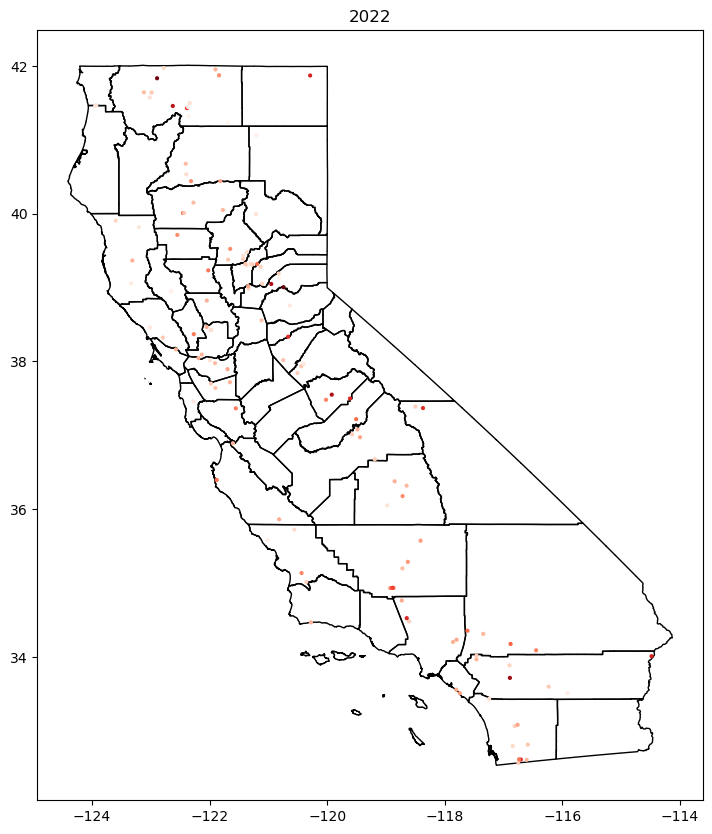

KeyboardInterrupt: 

In [58]:
%matplotlib inline
np.seterr(divide = 'ignore') 
year = 2013
while (True):
    choose = []
    for i in fires.index:
        if (str(fires["Started"][i]).split("-")[0] == str(year)):
            choose.append(True)
        else:
            choose.append(False)
    fires_plot = fires[choose]
    ax = world.plot(color = "none",edgecolor = 'black', figsize = (10,10))
    plt.scatter(fires_plot["Longitude"], fires_plot["Latitude"], c=np.log(fires_plot["AcresBurned"]), cmap="Reds", s=4)
    plt.title(year)
    plt.show()
    
    time.sleep(0.5)
    clear_output(wait=True)
    year += 1
    if (year == 2024):
        year = 2013

In [48]:
xmin, ymin, xmax, ymax= fires.total_bounds
n_cells=655.5
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = fires.crs
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = geopandas.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

In [68]:
xmax-xmin

9.715367

In [49]:
points = np.array((fires["Longitude"], fires["Latitude"])).T
values = np.array(fires['AcresBurned'])
xi = np.array((cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)).T

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_70838/2719937107.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  xi = np.array((cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)).T


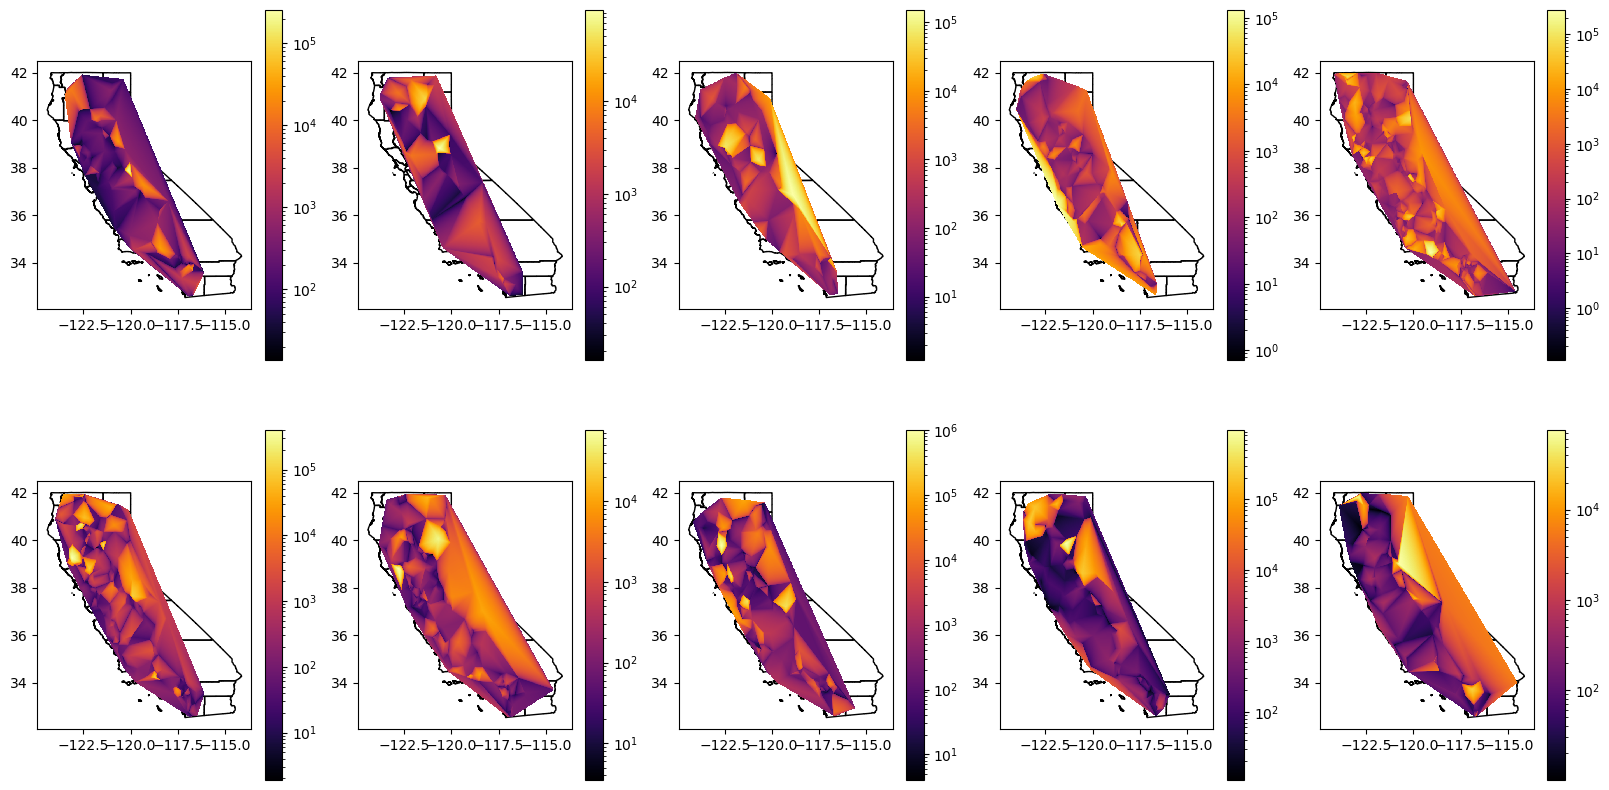

In [33]:
#tqdm this takes a long time
fig, axs = plt.subplots(2, 5, figsize = (20,10))
for i in range(2013, 2023):
    world.plot(ax = axs[(i-2013)//5, (i+2)%5], color = "none", edgecolor = 'black')
    
    
    choose = []
    for j in fires.index:
        if (str(fires["Started"][j]).split("-")[0] == str(i)):
            choose.append(True)
        else:
            choose.append(False)
            
    
    cell["interpolated_value"] = griddata(points[choose], values[choose], xi, method='linear')
    cell.plot(ax = axs[(i-2013)//5, (i+2)%5], column='interpolated_value', norm=colors.LogNorm(vmin=cell["interpolated_value"].min(), vmax=cell["interpolated_value"].max()), cmap='inferno', legend=True)
#     plt.autoscale(False)

In [57]:
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536> 
    """
    
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    
    # calculate hypotenuse
    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation 
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """
    
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)
    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)
def grid_idw(points, values, xi):
    if (len(points) != len(values)):
        raise ValueError
    return simple_idw(points.T[0], points.T[1], values, cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)


/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_70838/1647272271.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return simple_idw(points.T[0], points.T[1], values, cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)


<IPython.core.display.Javascript object>


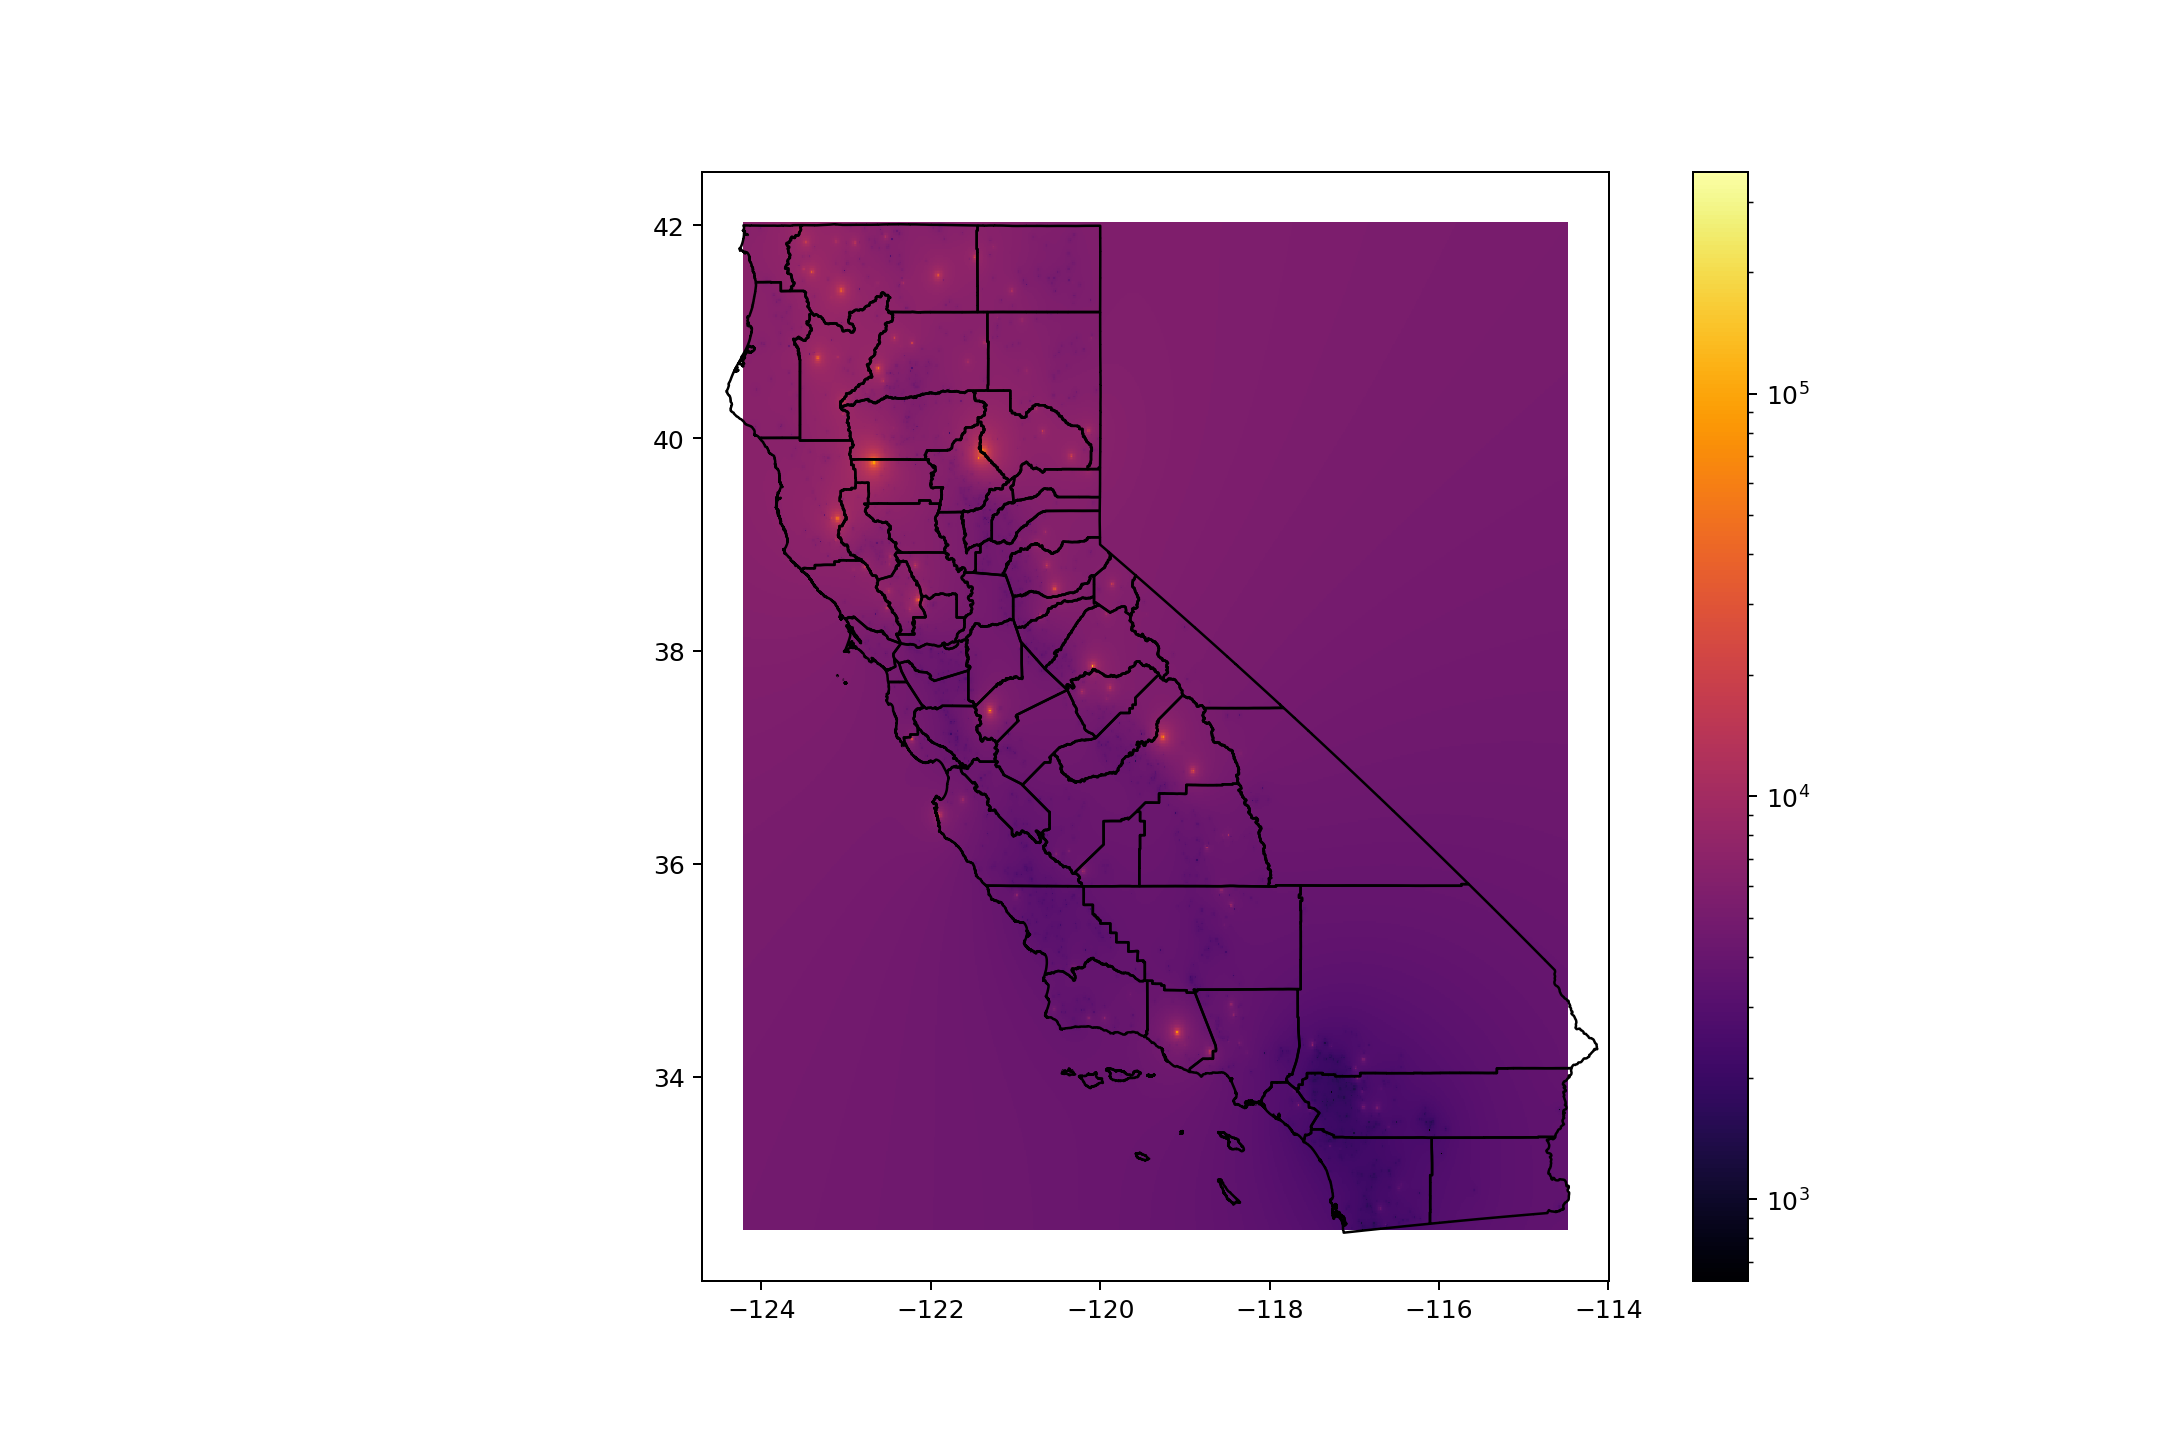

<Axes: >

In [40]:
%matplotlib notebook

ax = cell.plot(column='interpolated_value', figsize=(12, 8), norm=colors.LogNorm(vmin=cell["interpolated_value"].min(), vmax=cell["interpolated_value"].max()), cmap='inferno', legend=True)
plt.autoscale(False)
world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (12,8))

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_70838/2934582627.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return simple_idw(points.T[0], points.T[1], values, cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)


[1000. 1000. 1100. ...   26.   55.   24.]


<IPython.core.display.Javascript object>


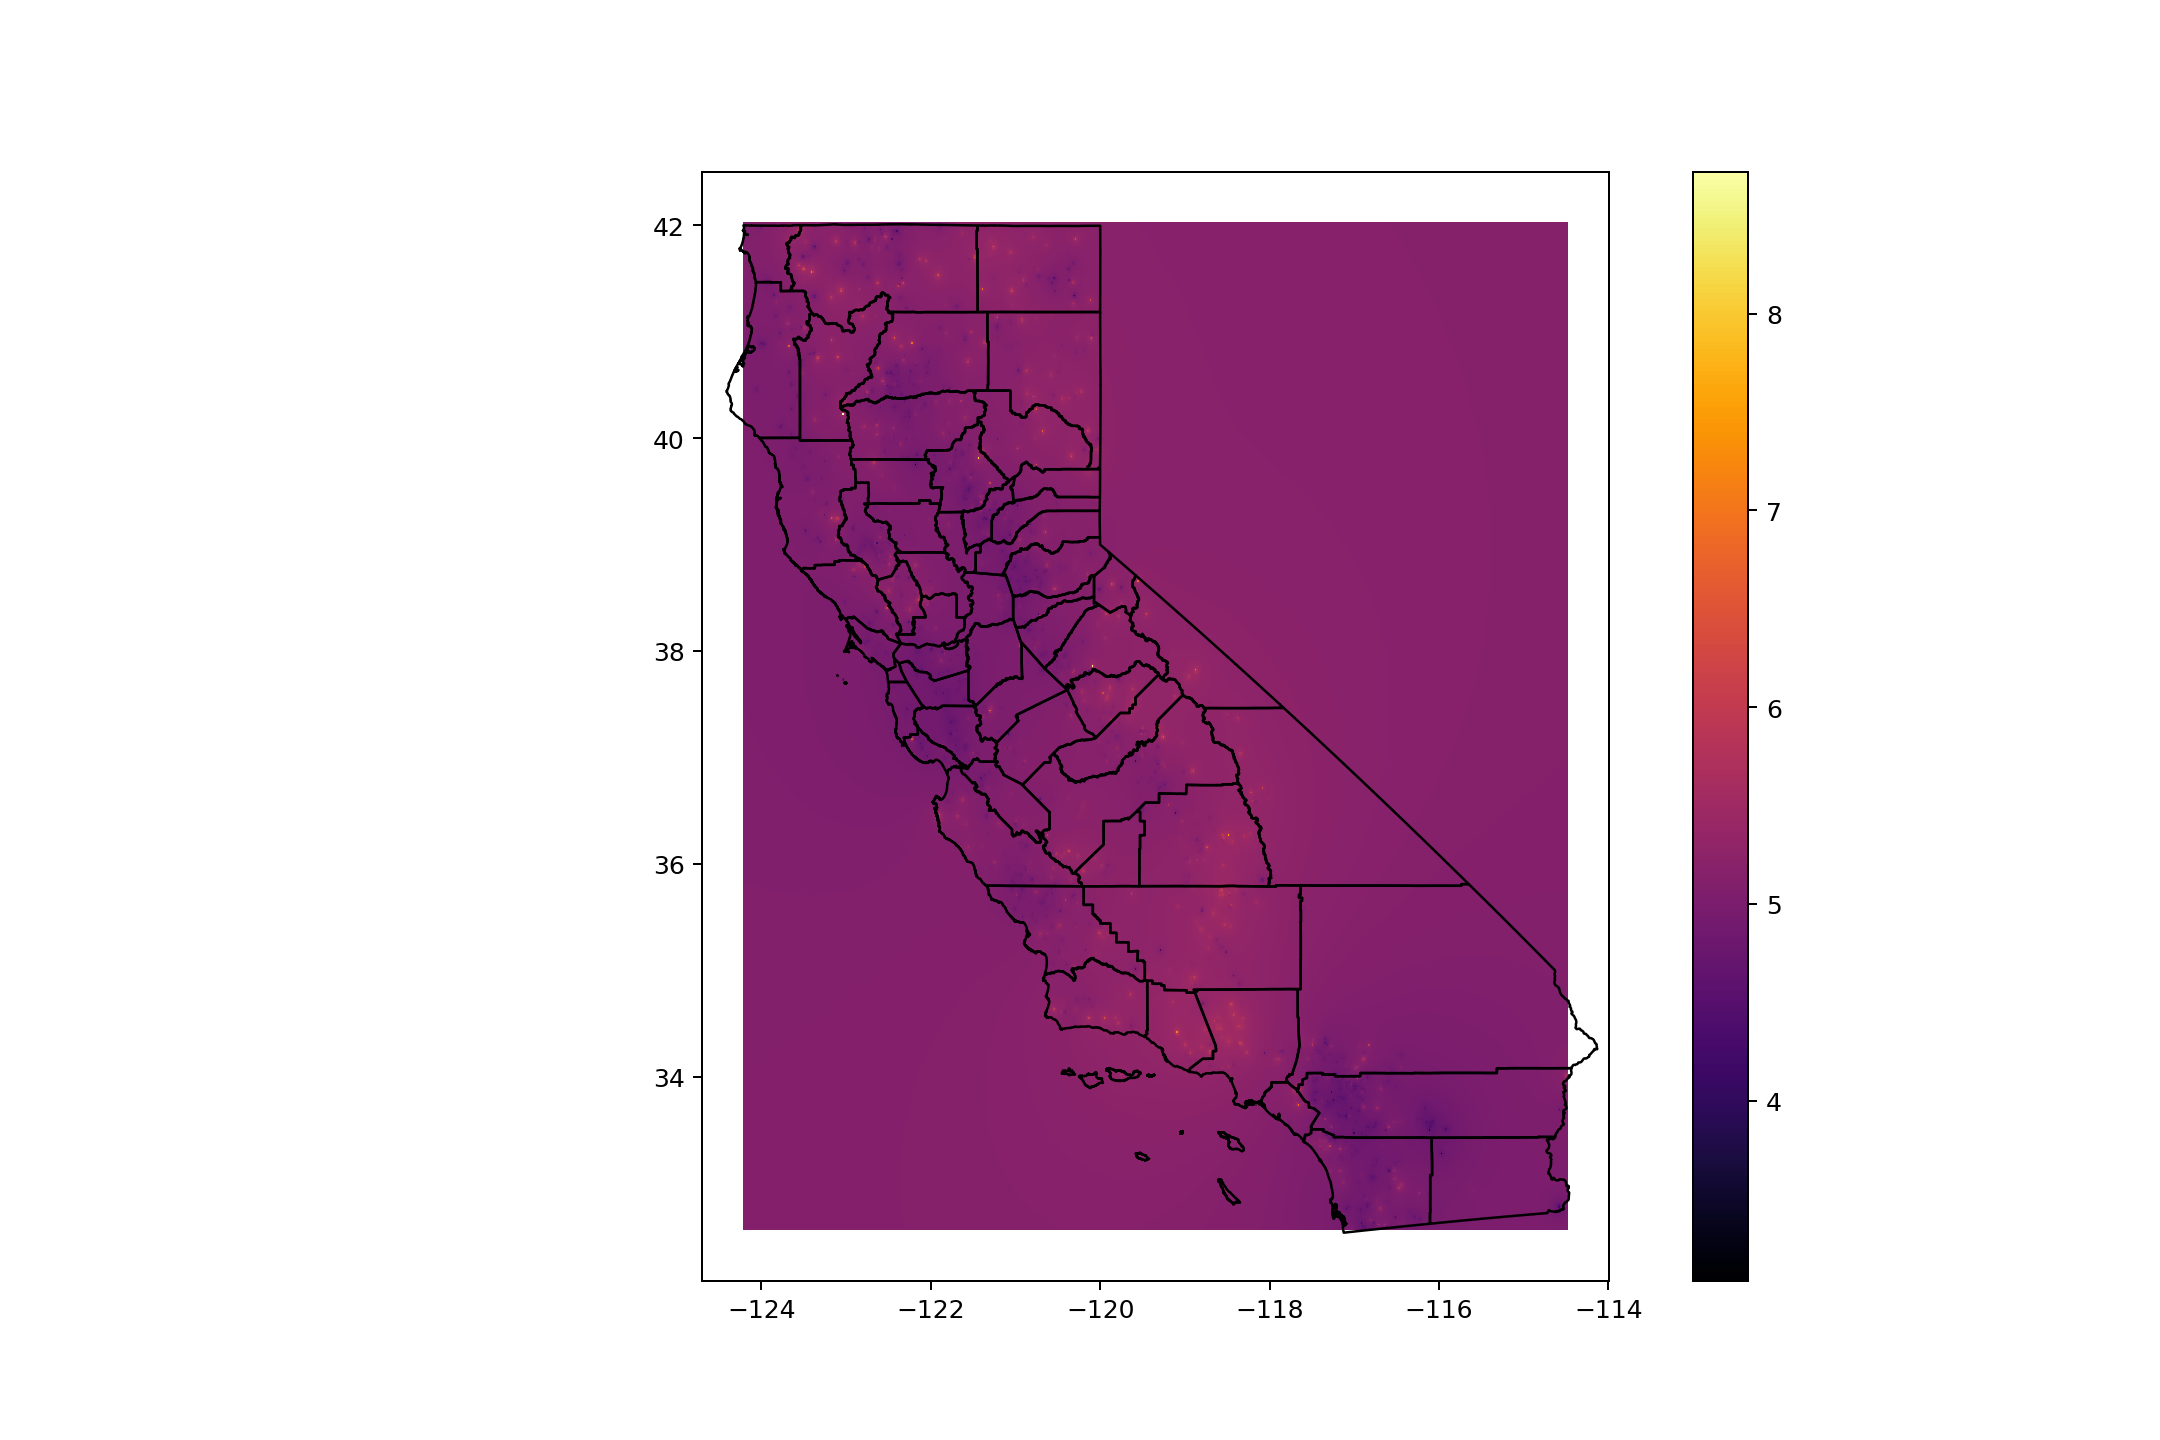

<Axes: >

In [54]:
%matplotlib notebook
cell["interpolated_value"] = grid_idw(points, np.log(values+2.7), xi)
ax = cell.plot(column='interpolated_value', figsize=(12, 8), cmap='inferno', legend=True)
plt.autoscale(False)
world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (12,8))

/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_70838/2149588891.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return simple_idw(points.T[0], points.T[1], values, cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)
/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_70838/2149588891.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return simple_idw(points.T[0], points.T[1], values, cell["geometry"].to_crs('epsg:4326').centroid.x, cell["geometry"].to_crs('epsg:4326').centroid.y)
/var/folders/xt/52zb2sgj4q9f84tyf9cg1yf00000gn/T/ipykernel_70838/2149588891.py:35: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are lik

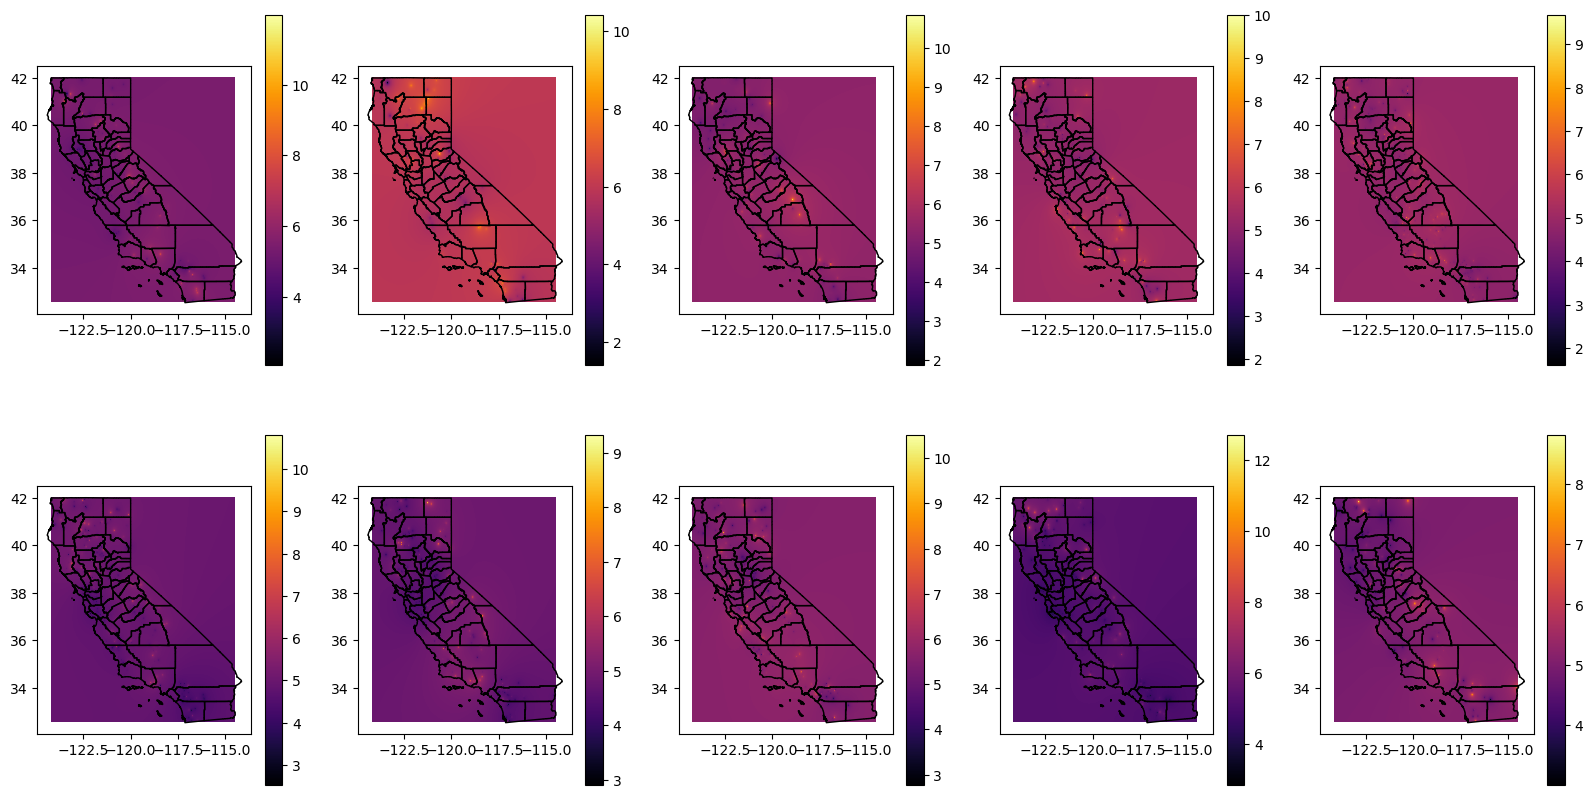

In [67]:
#tqdm this takes a long time
fig, axs = plt.subplots(2, 5, figsize = (20,10))
for i in range(2013, 2023):    
    
    choose = []
    for j in fires.index:
        if (str(fires["Started"][j]).split("-")[0] == str(i)):
            choose.append(True)
        else:
            choose.append(False)
            
    
    cell["interpolated_value"] = grid_idw(points[choose], np.log(values[choose]+2.7), xi)
    cell.plot(ax = axs[(i-2013)//5, (i+2)%5], column='interpolated_value', cmap='inferno', legend=True)
    world.plot(ax = axs[(i-2013)//5, (i+2)%5], color = "none", edgecolor = 'black')

    #     plt.autoscale(False)

In [44]:
np.log(values)

array([6.90775528, 6.90775528, 7.00306546, ..., 3.25809654, 4.00733319,
       3.17805383])

In [53]:
values+2.7

array([1002.7, 1002.7, 1102.7, ...,   28.7,   57.7,   26.7])

In [47]:
np.log(values)

array([6.90775528, 6.90775528, 7.00306546, ..., 3.25809654, 4.00733319,
       3.17805383])